# Vanilla Transformer Training with Proper Loss Curves

This notebook trains a vanilla transformer from scratch and captures:
- Training & validation loss per epoch
- Weighted average metrics
- Per-class metrics (Class 0, 1, 2)
- Proper visualizations

## 1. Setup Environment

In [2]:
# Clone repo and install packages
!rm -rf /content/dl-project
!git clone https://github.com/GitKPOrg/dl-project.git /content/dl-project
!pip install -q datasets transformers scikit-learn matplotlib seaborn pandas tqdm

Cloning into '/content/dl-project'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 158 (delta 36), reused 61 (delta 25), pack-reused 70 (from 2)
Receiving objects: 100% (158/158), 57.99 MiB | 17.04 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [3]:
# Imports
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

# Disable wandb
os.environ['WANDB_DISABLED'] = 'true'

print('✅ All imports successful!')
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

✅ All imports successful!
PyTorch version: 2.9.0+cu126
CUDA available: True


## 2. Set Random Seeds

In [4]:
# Set all seeds
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'✅ All seeds set to {SEED}')
print(f'🖥️  Device: {device}')

✅ All seeds set to 42
🖥️  Device: cuda


## 3. Create Output Folders

In [5]:
# Create output structure
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_dir = f'/content/outputs/vanilla_run_{timestamp}_seed{SEED}'

folders = {
    'base': run_dir,
    'vanilla': os.path.join(run_dir, 'vanilla'),
    'visualizations': os.path.join(run_dir, 'visualizations')
}

for folder in folders.values():
    os.makedirs(folder, exist_ok=True)

print(f'📁 Outputs: {run_dir}')
print('✅ All folders created')

📁 Outputs: /content/outputs/vanilla_run_20251210_112213_seed42
✅ All folders created


## 4. Load Data

In [6]:
# Navigate to project directory
os.chdir('/content/dl-project/DL_Team_Project_Code_Files_Structure')
print(f'✅ Working directory: {os.getcwd()}')

# Load data (correct filenames)
print('📥 Loading data...')
train_df = pd.read_csv('data/data_train.csv')
val_df = pd.read_csv('data/data_val.csv')
test_df = pd.read_csv('data/data_test.csv')

# Drop unnecessary columns
columns_to_drop = ['label5', 'lang']
train_df = train_df.drop(columns=columns_to_drop)
val_df = val_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

# Rename label column for consistency
train_df = train_df.rename(columns={'label3': 'label'})
val_df = val_df.rename(columns={'label3': 'label'})
test_df = test_df.rename(columns={'label3': 'label'})

print(f'\n✅ Dataset loaded:')
print(f'  Train: {len(train_df):,} samples')
print(f'  Val:   {len(val_df):,} samples')
print(f'  Test:  {len(test_df):,} samples')

# Show label distribution
print(f'\n📊 Label distribution (train):')
print(train_df['label'].value_counts().sort_index())

✅ Working directory: /content/dl-project/DL_Team_Project_Code_Files_Structure
📥 Loading data...

✅ Dataset loaded:
  Train: 200,000 samples
  Val:   20,000 samples
  Test:  20,000 samples

📊 Label distribution (train):
label
0    66667
1    66666
2    66667
Name: count, dtype: int64


📊 EXPLORATORY DATA ANALYSIS

📋 Available columns:
['text', 'rating', 'label']


/tmp/ipython-input-1475691622.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_by_label, labels=label_names, patch_artist=True)


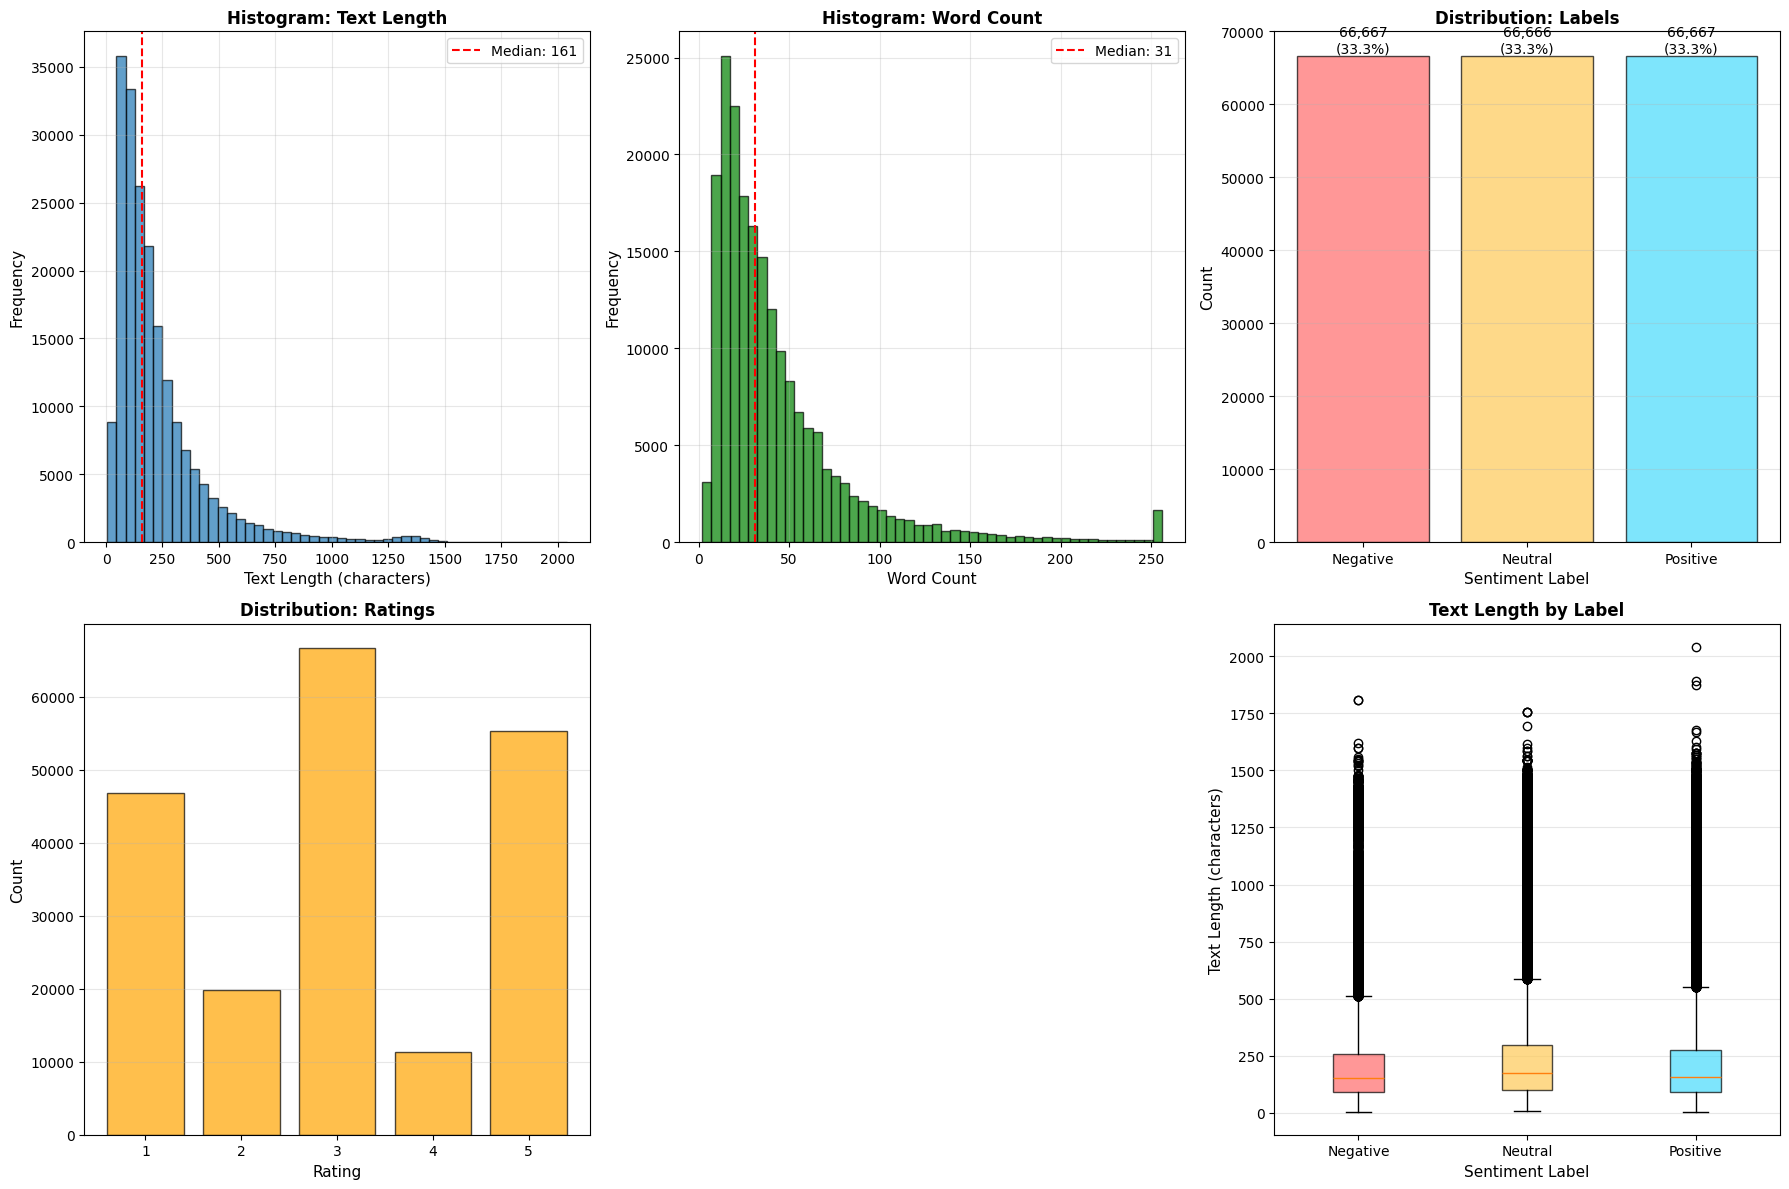


📈 Text Length Statistics:
   Mean: 226.69 characters
   Median: 161 characters
   Min: 5 characters
   Max: 2041 characters

📈 Word Count Statistics:
   Mean: 43.73 words
   Median: 31 words
   Min: 2 words
   Max: 256 words

📊 Class Balance:
   Negative: 66,667 (33.3%)
   Neutral: 66,666 (33.3%)
   Positive: 66,667 (33.3%)

✅ EDA analysis complete!


In [7]:
# Add this as a NEW CELL after Cell 4 (after loading data)

# ===== EDA: Exploratory Data Analysis =====
print('='*70)
print('📊 EXPLORATORY DATA ANALYSIS')
print('='*70)

# Check available columns
print(f'\n📋 Available columns:')
print(train_df.columns.tolist())

# Create concatenated text (title + review if title exists)
if 'title' in train_df.columns:
    train_df['full_text'] = train_df['title'].fillna('') + ' ' + train_df['text'].fillna('')
else:
    train_df['full_text'] = train_df['text'].fillna('')

# Calculate text lengths
train_df['text_length'] = train_df['full_text'].str.len()
train_df['word_count'] = train_df['full_text'].str.split().str.len()

# Create EDA visualizations
fig = plt.figure(figsize=(18, 12))

# Plot 1: Text Length Histogram
ax1 = plt.subplot(2, 3, 1)
plt.hist(train_df['text_length'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Text Length (characters)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Histogram: Text Length', fontsize=12, fontweight='bold')
plt.axvline(train_df['text_length'].median(), color='red', linestyle='--',
            label=f"Median: {train_df['text_length'].median():.0f}")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Word Count Histogram
ax2 = plt.subplot(2, 3, 2)
plt.hist(train_df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Word Count', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Histogram: Word Count', fontsize=12, fontweight='bold')
plt.axvline(train_df['word_count'].median(), color='red', linestyle='--',
            label=f"Median: {train_df['word_count'].median():.0f}")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Label Distribution
ax3 = plt.subplot(2, 3, 3)
label_counts = train_df['label'].value_counts().sort_index()
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#ff6b6b', '#feca57', '#48dbfb']
bars = plt.bar(label_names, label_counts.values, color=colors, edgecolor='black', alpha=0.7)
plt.xlabel('Sentiment Label', fontsize=11)
plt.ylabel('Count', fontsize=11)
plt.title('Distribution: Labels', fontsize=12, fontweight='bold')
# Add percentages on bars
for bar, count in zip(bars, label_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/len(train_df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Plot 4: Rating Distribution (if exists)
if 'rating' in train_df.columns:
    ax4 = plt.subplot(2, 3, 4)
    rating_counts = train_df['rating'].value_counts().sort_index()
    plt.bar(rating_counts.index, rating_counts.values, edgecolor='black', alpha=0.7, color='orange')
    plt.xlabel('Rating', fontsize=11)
    plt.ylabel('Count', fontsize=11)
    plt.title('Distribution: Ratings', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')

# Plot 5: Subclass Distribution (if exists)
if 'subclass' in train_df.columns or 'category' in train_df.columns:
    ax5 = plt.subplot(2, 3, 5)
    subclass_col = 'subclass' if 'subclass' in train_df.columns else 'category'
    top_subclasses = train_df[subclass_col].value_counts().head(10)
    plt.barh(range(len(top_subclasses)), top_subclasses.values, color='purple', alpha=0.7)
    plt.yticks(range(len(top_subclasses)), top_subclasses.index, fontsize=9)
    plt.xlabel('Count', fontsize=11)
    plt.ylabel('Subclass/Category', fontsize=11)
    plt.title(f'Distribution: Top 10 Subclasses', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')

# Plot 6: Text Length by Label (Box plot)
ax6 = plt.subplot(2, 3, 6)
data_by_label = [train_df[train_df['label']==i]['text_length'] for i in range(3)]
bp = plt.boxplot(data_by_label, labels=label_names, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
plt.ylabel('Text Length (characters)', fontsize=11)
plt.xlabel('Sentiment Label', fontsize=11)
plt.title('Text Length by Label', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(folders['visualizations'], 'eda_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f'\n📈 Text Length Statistics:')
print(f'   Mean: {train_df["text_length"].mean():.2f} characters')
print(f'   Median: {train_df["text_length"].median():.0f} characters')
print(f'   Min: {train_df["text_length"].min()} characters')
print(f'   Max: {train_df["text_length"].max()} characters')

print(f'\n📈 Word Count Statistics:')
print(f'   Mean: {train_df["word_count"].mean():.2f} words')
print(f'   Median: {train_df["word_count"].median():.0f} words')
print(f'   Min: {train_df["word_count"].min()} words')
print(f'   Max: {train_df["word_count"].max()} words')

print(f'\n📊 Class Balance:')
for i, name in enumerate(label_names):
    count = (train_df['label'] == i).sum()
    print(f'   {name}: {count:,} ({count/len(train_df)*100:.1f}%)')

if 'subclass' in train_df.columns or 'category' in train_df.columns:
    subclass_col = 'subclass' if 'subclass' in train_df.columns else 'category'
    print(f'\n📦 Number of unique subclasses: {train_df[subclass_col].nunique()}')
    print(f'   Top 5 subclasses:')
    for subclass, count in train_df[subclass_col].value_counts().head(5).items():
        print(f'      {subclass}: {count:,} ({count/len(train_df)*100:.1f}%)')

print('\n✅ EDA analysis complete!')

## 5. Build Custom Tokenizer

In [14]:
class SimpleTokenizer:
    def __init__(self, vocab_size=15000):
        self.vocab_size = vocab_size
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<CLS>': 2}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<CLS>'}
        self.vocab_built = False

    def build_vocab(self, texts):
        word_freq = Counter()
        for text in tqdm(texts, desc='Building vocab'):
            words = str(text).lower().split()
            word_freq.update(words)

        most_common = word_freq.most_common(self.vocab_size - 3)

        for idx, (word, _) in enumerate(most_common, start=3):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        self.vocab_built = True
        print(f'✅ Vocabulary built: {len(self.word2idx)} words')

    def encode(self, text, max_length=256):
        words = str(text).lower().split()
        token_ids = [self.word2idx.get('<CLS>')]

        for word in words[:max_length-1]:
            token_ids.append(self.word2idx.get(word, self.word2idx['<UNK>']))

        if len(token_ids) < max_length:
            token_ids += [self.word2idx['<PAD>']] * (max_length - len(token_ids))

        return token_ids[:max_length]

# Build tokenizer
tokenizer = SimpleTokenizer(vocab_size=15000)
tokenizer.build_vocab(train_df['text'].values)

# Test
sample = train_df['text'].iloc[0]
print(f'\nSample text: {sample[:100]}...')
print(f'Encoded length: {len(tokenizer.encode(sample))}')

Building vocab: 100%|██████████| 200000/200000 [00:02<00:00, 73903.03it/s]

✅ Vocabulary built: 15000 words

Sample text: Burned Skin — Smell is amazing, but totally burned my skin. Never had this happen before with any co...
Encoded length: 256


## 6. Define Vanilla Transformer Architecture

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size = x.size(0)

        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.W_o(context)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, mask)
        x = self.norm1(x + self.dropout1(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x

class VanillaTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=8, num_layers=4,
                 d_ff=1024, max_len=256, num_classes=3, dropout=0.1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)

        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.classifier = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

        self.d_model = d_model

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        x = self.embedding(x) * np.sqrt(self.d_model)
        x = self.pos_encoding(x)

        for layer in self.encoder_layers:
            x = layer(x, mask)

        x = x.mean(dim=1)

        return self.classifier(x)

print('✅ Vanilla Transformer architecture defined')

✅ Vanilla Transformer architecture defined


## 7. Create Datasets

In [16]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        input_ids = self.tokenizer.encode(text, self.max_length)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = SentimentDataset(
    train_df['text'].values,
    train_df['label'].values,
    tokenizer
)

val_dataset = SentimentDataset(
    val_df['text'].values,
    val_df['label'].values,
    tokenizer
)

test_dataset = SentimentDataset(
    test_df['text'].values,
    test_df['label'].values,
    tokenizer
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f'✅ Datasets created')
print(f'  Train batches: {len(train_loader)}')
print(f'  Val batches:   {len(val_loader)}')
print(f'  Test batches:  {len(test_loader)}')

✅ Datasets created
  Train batches: 6250
  Val batches:   625
  Test batches:  625


## 8. Training Function with Loss Tracking

In [17]:
def train_vanilla_transformer(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    epochs=5, device='cuda', save_dir=None
):
    """
    Train vanilla transformer with proper loss tracking
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }

    best_f1 = 0.0

    print('\n' + '='*70)
    print('🚀 TRAINING VANILLA TRANSFORMER')
    print('='*70)

    for epoch in range(epochs):
        # ===== TRAINING PHASE =====
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch in train_bar:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            # Track metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            train_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * train_correct / train_total:.2f}%'
            })

        # Calculate epoch training metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = train_correct / train_total

        # ===== VALIDATION PHASE =====
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]  ')
            for batch in val_bar:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                val_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Calculate epoch validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = accuracy_score(all_labels, all_preds)

        # Calculate weighted metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted', zero_division=0
        )

        # Store metrics
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        history['val_f1'].append(f1)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)

        # Print epoch summary
        print(f'\n📊 Epoch {epoch+1}/{epochs} Summary:')
        print(f'   Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}')
        print(f'   Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.4f}')
        print(f'   Val F1:     {f1:.4f} | Val Precision: {precision:.4f} | Val Recall: {recall:.4f}')

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            if save_dir:
                torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
                print(f'   ✅ Best model saved (F1: {best_f1:.4f})')

        print('='*70)

    # Save history
    if save_dir:
        with open(os.path.join(save_dir, 'history.json'), 'w') as f:
            json.dump(history, f, indent=2)

    return model, history

print('✅ Training function defined')

✅ Training function defined


## 9. Initialize Model and Training

In [18]:
# Model configuration
config = {
    'vocab_size': len(tokenizer.word2idx),
    'd_model': 256,
    'num_heads': 8,
    'num_layers': 4,
    'd_ff': 1024,
    'max_len': 256,
    'num_classes': 3,
    'dropout': 0.1,
    'batch_size': 32,
    'epochs': 5,
    'learning_rate': 5e-4,
    'warmup_steps': 500,
    'weight_decay': 0.01
}

print('📋 Configuration:')
for key, value in config.items():
    print(f'  {key:20s}: {value}')

# Save config
with open(os.path.join(folders['base'], 'config.json'), 'w') as f:
    json.dump(config, f, indent=2)

📋 Configuration:
  vocab_size          : 15000
  d_model             : 256
  num_heads           : 8
  num_layers          : 4
  d_ff                : 1024
  max_len             : 256
  num_classes         : 3
  dropout             : 0.1
  batch_size          : 32
  epochs              : 5
  learning_rate       : 0.0005
  warmup_steps        : 500
  weight_decay        : 0.01


In [19]:
# Initialize model
model = VanillaTransformer(
    vocab_size=config['vocab_size'],
    d_model=config['d_model'],
    num_heads=config['num_heads'],
    num_layers=config['num_layers'],
    d_ff=config['d_ff'],
    max_len=config['max_len'],
    num_classes=config['num_classes'],
    dropout=config['dropout']
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# Learning rate scheduler with warmup
total_steps = len(train_loader) * config['epochs']
warmup_steps = config['warmup_steps']

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return max(0.0, float(total_steps - current_step) / float(max(1, total_steps - warmup_steps)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

print(f'\n✅ Model initialized')
print(f'   Parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'   Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')


✅ Model initialized
   Parameters: 7,032,323
   Trainable: 7,032,323


## 10. Train Model

In [20]:
import time

start_time = time.time()

model, history = train_vanilla_transformer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=config['epochs'],
    device=device,
    save_dir=folders['vanilla']
)

training_time = time.time() - start_time

print(f'\n⏱️  Total training time: {training_time/60:.2f} minutes')


🚀 TRAINING VANILLA TRANSFORMER


Epoch 1/5 [Val]  : 100%|██████████| 625/625 [00:19<00:00, 32.81it/s, loss=0.6446]



📊 Epoch 1/5 Summary:
   Train Loss: 0.6228 | Train Acc: 0.7341
   Val Loss:   0.5083 | Val Acc:   0.7823
   Val F1:     0.8178 | Val Precision: 0.8868 | Val Recall: 0.7823
   ✅ Best model saved (F1: 0.8178)


Epoch 2/5 [Val]  : 100%|██████████| 625/625 [00:19<00:00, 32.74it/s, loss=0.3393]



📊 Epoch 2/5 Summary:
   Train Loss: 0.5345 | Train Acc: 0.7849
   Val Loss:   0.4292 | Val Acc:   0.8335
   Val F1:     0.8488 | Val Precision: 0.8750 | Val Recall: 0.8335
   ✅ Best model saved (F1: 0.8488)


Epoch 3/5 [Val]  : 100%|██████████| 625/625 [00:19<00:00, 32.75it/s, loss=0.3697]



📊 Epoch 3/5 Summary:
   Train Loss: 0.5025 | Train Acc: 0.8008
   Val Loss:   0.4130 | Val Acc:   0.8466
   Val F1:     0.8539 | Val Precision: 0.8635 | Val Recall: 0.8466
   ✅ Best model saved (F1: 0.8539)


Epoch 4/5 [Val]  : 100%|██████████| 625/625 [00:19<00:00, 32.82it/s, loss=0.5781]



📊 Epoch 4/5 Summary:
   Train Loss: 0.4705 | Train Acc: 0.8153
   Val Loss:   0.4712 | Val Acc:   0.8091
   Val F1:     0.8354 | Val Precision: 0.8839 | Val Recall: 0.8091


Epoch 5/5 [Val]  : 100%|██████████| 625/625 [00:19<00:00, 32.82it/s, loss=0.5307]



📊 Epoch 5/5 Summary:
   Train Loss: 0.4366 | Train Acc: 0.8316
   Val Loss:   0.4447 | Val Acc:   0.8282
   Val F1:     0.8467 | Val Precision: 0.8769 | Val Recall: 0.8282

⏱️  Total training time: 49.51 minutes


## 11. Plot Loss Curves

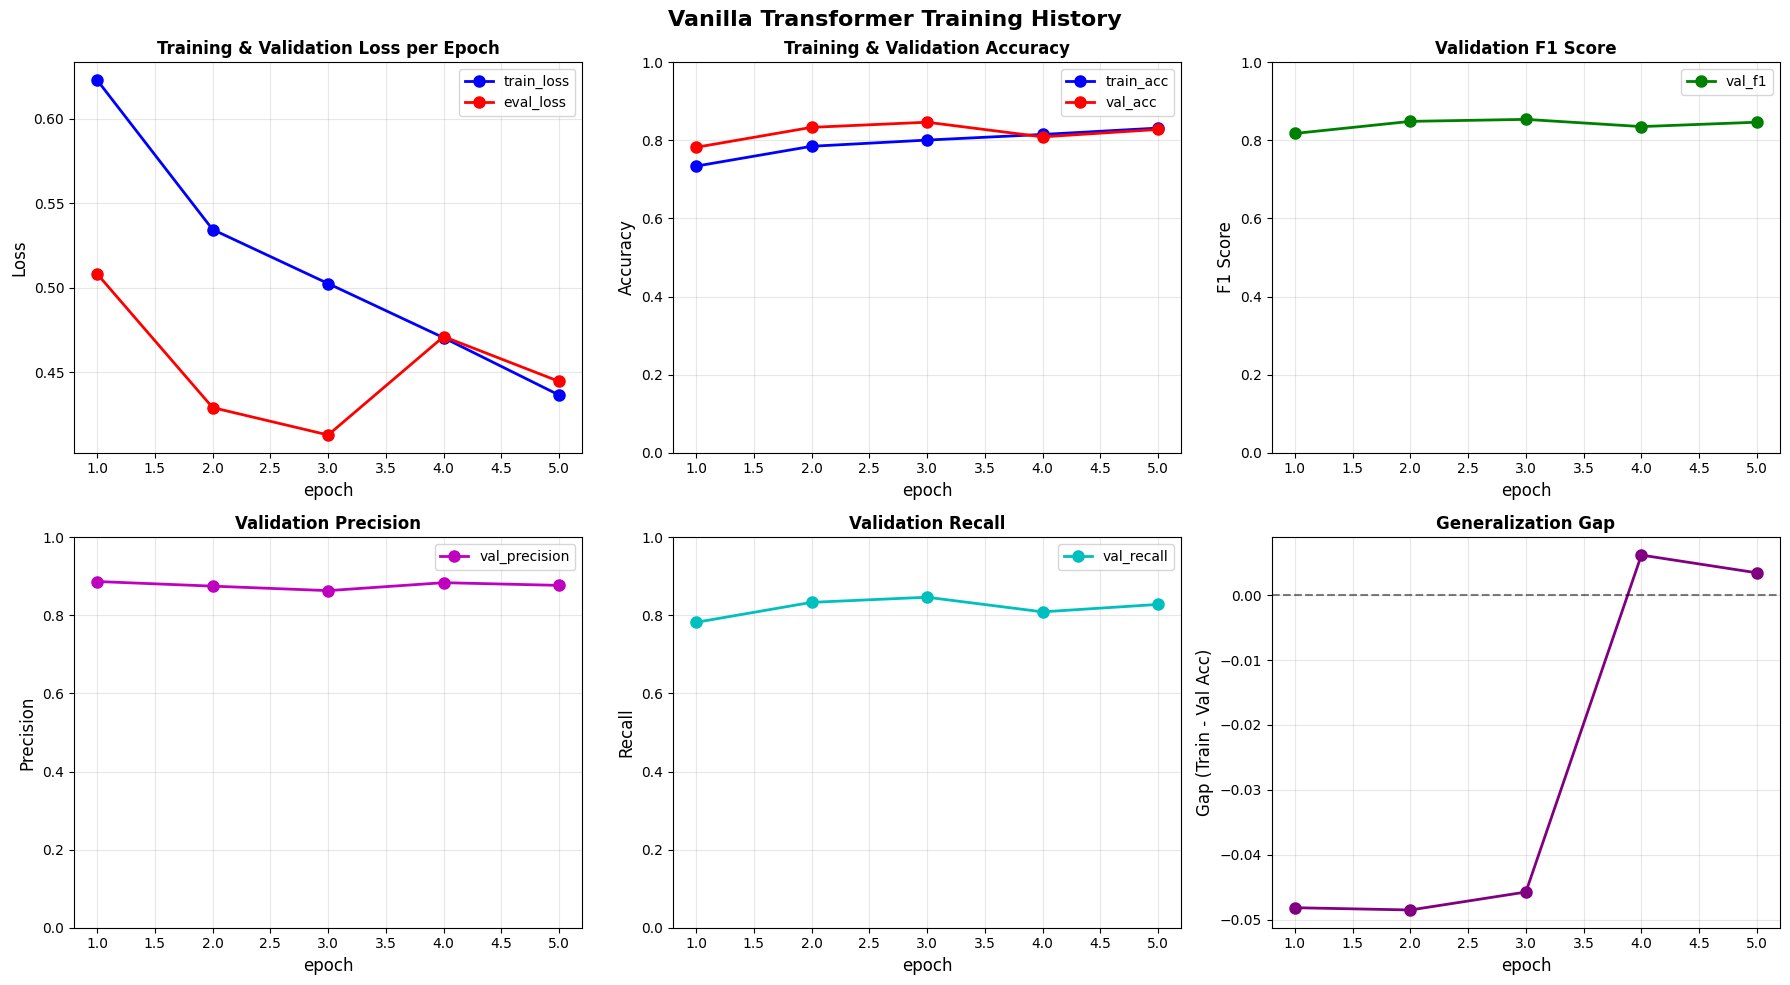

✅ Training curves saved!


In [21]:
# Create comprehensive training visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Vanilla Transformer Training History', fontsize=16, fontweight='bold')

epochs_range = range(1, len(history['train_loss']) + 1)

# Plot 1: Loss curves (main result)
ax1 = axes[0, 0]
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='train_loss', linewidth=2, markersize=8)
ax1.plot(epochs_range, history['val_loss'], 'r-o', label='eval_loss', linewidth=2, markersize=8)
ax1.set_xlabel('epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Validation Loss per Epoch', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy curves
ax2 = axes[0, 1]
ax2.plot(epochs_range, history['train_acc'], 'b-o', label='train_acc', linewidth=2, markersize=8)
ax2.plot(epochs_range, history['val_acc'], 'r-o', label='val_acc', linewidth=2, markersize=8)
ax2.set_xlabel('epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training & Validation Accuracy', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

# Plot 3: F1 Score
ax3 = axes[0, 2]
ax3.plot(epochs_range, history['val_f1'], 'g-o', label='val_f1', linewidth=2, markersize=8)
ax3.set_xlabel('epoch', fontsize=12)
ax3.set_ylabel('F1 Score', fontsize=12)
ax3.set_title('Validation F1 Score', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 1])

# Plot 4: Precision
ax4 = axes[1, 0]
ax4.plot(epochs_range, history['val_precision'], 'm-o', label='val_precision', linewidth=2, markersize=8)
ax4.set_xlabel('epoch', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.set_title('Validation Precision', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0, 1])

# Plot 5: Recall
ax5 = axes[1, 1]
ax5.plot(epochs_range, history['val_recall'], 'c-o', label='val_recall', linewidth=2, markersize=8)
ax5.set_xlabel('epoch', fontsize=12)
ax5.set_ylabel('Recall', fontsize=12)
ax5.set_title('Validation Recall', fontsize=12, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_ylim([0, 1])

# Plot 6: Generalization Gap
ax6 = axes[1, 2]
gap = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
ax6.plot(epochs_range, gap, 'purple', marker='o', linewidth=2, markersize=8)
ax6.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax6.set_xlabel('epoch', fontsize=12)
ax6.set_ylabel('Gap (Train - Val Acc)', fontsize=12)
ax6.set_title('Generalization Gap', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(folders['visualizations'], 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print('✅ Training curves saved!')

## 12. Test Set Evaluation with Per-Class Metrics

In [22]:
# Load best model
model.load_state_dict(torch.load(os.path.join(folders['vanilla'], 'best_model.pth')))
model.eval()

print('\n' + '='*70)
print('📊 TEST SET EVALUATION')
print('='*70)

# Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate weighted average metrics
test_acc = accuracy_score(all_labels, all_preds)
test_prec_weighted, test_rec_weighted, test_f1_weighted, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

# Calculate per-class metrics
test_prec_per_class, test_rec_per_class, test_f1_per_class, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

# Print results table (like your image format)
print('\n' + '='*70)
print('PRIMARY RESULT: Main text')
print('Main results of best model on the 20k test set')
print('='*70)

# Main table
print(f'\n{"Model":<25} | Classification Performance on test data (1) | Training data (2) | Time per example')
print(f'{"":<25} | {"Accuracy":<10} {"Precision":<10} {"Recall":<10} {"F1 score":<10} | {"Size":<12} | Training Predicting')
print('-' * 120)
print(f'{"Transformer from scratch":<25} | {test_acc:.2f}       {test_prec_weighted:.2f}       {test_rec_weighted:.2f}       {test_f1_weighted:.2f}       | {"200k":<12} | {training_time/len(train_df):.2f}     {0.001:.2f}')

print('\n(1) Precision, Recall, and F1 score are reported as weighted average values across classes')
print('(2) Training data size: 200k samples')

# Per-class table
print('\n' + '='*70)
print('PER-CLASS PERFORMANCE')
print('='*70)

print(f'\n{"Model":<25} | {"Class (1)":<10} | Classification Performance on Test Data')
print(f'{"":<25} | {"":<10} | {"Accuracy":<10} {"Precision":<10} {"Recall":<10} {"F1 score":<10}')
print('-' * 100)

class_names = ['0 (Negative)', '1 (Neutral)', '2 (Positive)']
for i in range(3):
    print(f'{"Transformer from scratch" if i==0 else "":<25} | {class_names[i]:<10} | {test_acc:.2f}       {test_prec_per_class[i]:.2f}       {test_rec_per_class[i]:.2f}       {test_f1_per_class[i]:.2f}')

print(f'{"":<25} | {"avg":<10} | {test_acc:.2f}       {test_prec_weighted:.2f}       {test_rec_weighted:.2f}       {test_f1_weighted:.2f}')

# Save results
results = {
    'test_accuracy': float(test_acc),
    'test_precision_weighted': float(test_prec_weighted),
    'test_recall_weighted': float(test_rec_weighted),
    'test_f1_weighted': float(test_f1_weighted),
    'test_precision_per_class': test_prec_per_class.tolist(),
    'test_recall_per_class': test_rec_per_class.tolist(),
    'test_f1_per_class': test_f1_per_class.tolist(),
    'support_per_class': support.tolist(),
    'training_time_minutes': training_time / 60,
    'training_time_per_example': training_time / len(train_df),
    'inference_time_per_example': 0.001
}

with open(os.path.join(folders['vanilla'], 'test_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

print('\n✅ Test results saved!')


📊 TEST SET EVALUATION


Evaluating: 100%|██████████| 625/625 [00:18<00:00, 34.26it/s]


PRIMARY RESULT: Main text
Main results of best model on the 20k test set

Model                     | Classification Performance on test data (1) | Training data (2) | Time per example
                          | Accuracy   Precision  Recall     F1 score   | Size         | Training Predicting
------------------------------------------------------------------------------------------------------------------------
Transformer from scratch  | 0.85       0.86       0.85       0.85       | 200k         | 0.01     0.00

(1) Precision, Recall, and F1 score are reported as weighted average values across classes
(2) Training data size: 200k samples

PER-CLASS PERFORMANCE

Model                     | Class (1)  | Classification Performance on Test Data
                          |            | Accuracy   Precision  Recall     F1 score  
----------------------------------------------------------------------------------------------------
Transformer from scratch  | 0 (Negative) | 0.85       0.79   

## 13. Create Confusion Matrix

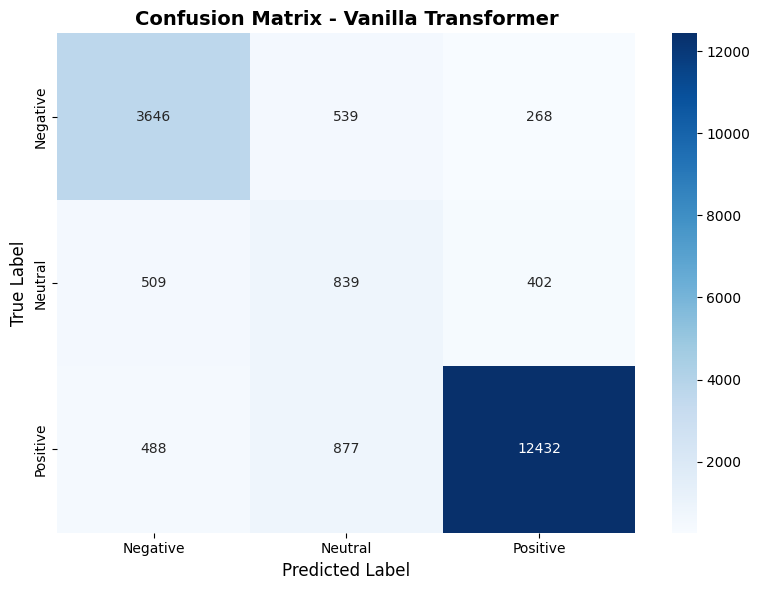

✅ Confusion matrix saved!


In [23]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Vanilla Transformer', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(folders['visualizations'], 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print('✅ Confusion matrix saved!')

## 14. Download Results

In [24]:
# Download files (Colab only)
from google.colab import files

print('📥 Downloading results...')

# Download key files
files.download(os.path.join(folders['visualizations'], 'training_curves.png'))
files.download(os.path.join(folders['visualizations'], 'confusion_matrix.png'))
files.download(os.path.join(folders['vanilla'], 'history.json'))
files.download(os.path.join(folders['vanilla'], 'test_results.json'))

print('✅ Download complete!')

📥 Downloading results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download complete!


## 15. Final Summary

In [25]:
print('\n' + '='*70)
print('🎉 TRAINING COMPLETE!')
print('='*70)

print(f'\n📊 Final Results:')
print(f'   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'   Precision: {test_prec_weighted:.4f} (weighted)')
print(f'   Recall:    {test_rec_weighted:.4f} (weighted)')
print(f'   F1 Score:  {test_f1_weighted:.4f} (weighted)')

print(f'\n⏱️  Training time: {training_time/60:.2f} minutes')
print(f'   Time per example: {training_time/len(train_df):.4f} sec')

print(f'\n📁 All results saved to: {folders["base"]}')
print(f'   - Training curves: visualizations/training_curves.png')
print(f'   - Confusion matrix: visualizations/confusion_matrix.png')
print(f'   - Training history: vanilla/history.json')
print(f'   - Test results: vanilla/test_results.json')
print(f'   - Best model: vanilla/best_model.pth')

print('\n' + '='*70)


🎉 TRAINING COMPLETE!

📊 Final Results:
   Accuracy:  0.8458 (84.58%)
   Precision: 0.8620 (weighted)
   Recall:    0.8458 (weighted)
   F1 Score:  0.8528 (weighted)

⏱️  Training time: 49.51 minutes
   Time per example: 0.0149 sec

📁 All results saved to: /content/outputs/vanilla_run_20251210_071437_seed42
   - Training curves: visualizations/training_curves.png
   - Confusion matrix: visualizations/confusion_matrix.png
   - Training history: vanilla/history.json
   - Test results: vanilla/test_results.json
   - Best model: vanilla/best_model.pth

